In [1]:
!pip install fastbook

     |████████████████████████████████| 727kB 2.8MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 194kB 10.7MB/s 
     |████████████████████████████████| 1.0MB 13.9MB/s 
     |████████████████████████████████| 40kB 6.5MB/s 
     |████████████████████████████████| 40kB 7.2MB/s 
     |████████████████████████████████| 92kB 10.4MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 2.6MB 21.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
root_dir = '/content'

In [3]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [4]:
from fastbook import *
from fastai.vision.widgets import *

In [5]:
path = Path(root_dir + '/whatsapp')
classes = ['scanned', 'wishes']
for folder in classes:
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)

In [6]:
for folder in classes:
  dest = path/folder
  file_name = str(folder) + ".txt"
  download_images(url_file=dest/file_name, dest=dest, max_pics=200)

In [7]:
fns = get_image_files(path)

In [8]:
fns[:5]

(#5) [Path('/content/whatsapp/scanned/00000147.jpg'),Path('/content/whatsapp/scanned/00000135.jpg'),Path('/content/whatsapp/scanned/00000046.jpg'),Path('/content/whatsapp/scanned/00000149.jpg'),Path('/content/whatsapp/scanned/00000057.jpg')]

In [9]:
failed = verify_images(fns)

In [10]:
failed.map(Path.unlink)

(#0) []

In [47]:
path

Path('/content/whatsapp')

In [65]:
def get_y(r): return str(r).split('/')[-2][0].strip()

In [66]:
get_y(path)

# working with single character because multiple characters are being taken as a single label

'c'

In [67]:
whatsapp = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                     get_items=get_image_files,
                     get_y=get_y,
                     splitter=RandomSplitter(valid_pct=0.2, seed=42),
                     item_tfms= RandomResizedCrop(128, min_scale=0.35))

In [40]:
dsets = whatsapp.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=149x198,
 TensorMultiCategory([1., 1., 1., 1., 0., 0., 1., 1., 0.]))

In [68]:
dls =  whatsapp.dataloaders(path)

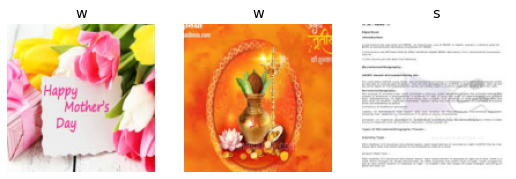

In [69]:
dls.valid.show_batch(nrows=1, ncols=3)

In [74]:
whatsapp = whatsapp.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

In [75]:
dls = whatsapp.dataloaders(path)

In [76]:
learn = cnn_learner(dls, resnet18)

In [77]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

# batch size is 64 and we have 2 categories

torch.Size([64, 2])

In [78]:
activs[0]

tensor([-2.5497, -2.2866], grad_fn=<SelectBackward>)

In [79]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [84]:
learn = cnn_learner(dls, resnet50,metrics=partial(accuracy_multi, thresh=0.2) )
learn.fine_tune(4, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.584161,0.517180,0.757812,00:02
1,0.418573,0.375719,0.898438,00:02
2,0.305871,0.282685,0.898438,00:02
3,0.252200,0.193996,0.906250,00:02


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.070530,0.154005,0.937500,00:02
1,0.040032,0.126786,0.960938,00:02
2,0.038014,0.141548,0.945312,00:02
3,0.030666,0.137694,0.953125,00:02


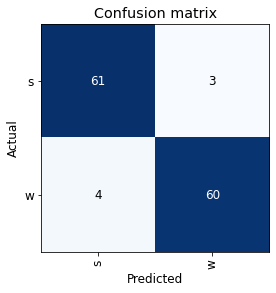

In [85]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

,target,predicted,probabilities,loss
0,w,s,"tensor([0.9723, 0.0277])",3.5866775512695312
1,s,w,"tensor([0.0529, 0.9194])",2.728243350982666
2,w,s,"tensor([0.6222, 0.2261])",1.2301368713378906
3,w,,"tensor([0.0045, 0.2907])",0.6199014782905579
4,s,s,"tensor([0.9193, 0.3047])",0.22379259765148163
5,s,s,"tensor([0.7527, 0.0756])",0.1813097894191742
6,w,w,"tensor([0.0961, 0.9207])",0.09181570261716843
7,s,s,"tensor([0.8360, 0.0030])",0.09104815870523453
8,s,s,"tensor([0.9493, 0.0042])",0.02811560221016407
9,s,s,"tensor([0.9757, 0.0052])",0.014926612377166748


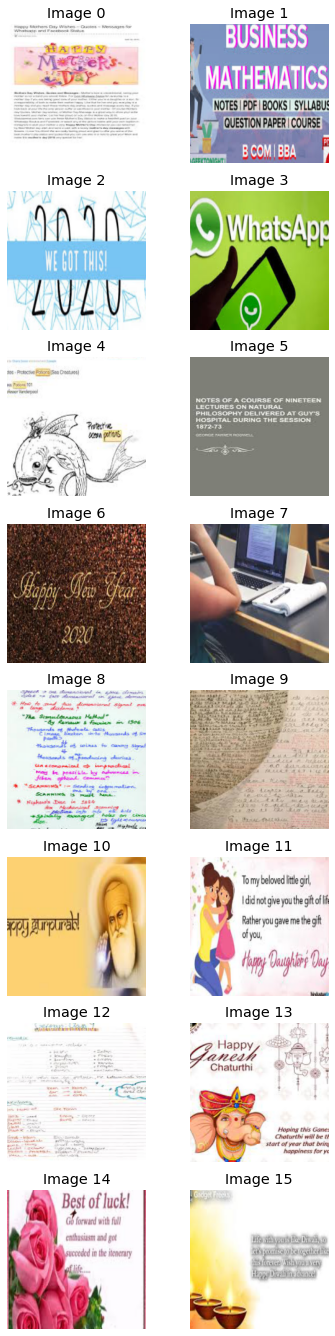

In [86]:
interp.plot_top_losses(16, nrows=8)

In [87]:
cleaner = ImageClassifierCleaner(learn)

In [88]:
cleaner

In [89]:
learn.export()

In [90]:
learn.predict("/content/whatsapp/scanned/00000147.jpg")

((#1) ['s'], tensor([ True, False]), tensor([1.0000e+00, 5.1988e-08]))

In [91]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [93]:
img =   PILImage.create(btn_upload.data[-1])

In [94]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [95]:
pred, pred_idx, probs = learn.predict(img)

In [98]:
pred, pred_idx, probs

((#1) ['w'], tensor([False,  True]), tensor([0.4032, 0.7952]))

In [99]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]}'
lbl_pred

Label(value="Prediction: (#1) ['w']; Probability: tensor([0.7952])")

In [100]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [101]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred, pred_idx, probs = learn.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
  #print(lbl_pred)

btn_run.on_click(on_click_classify)

In [102]:
btn_upload =widgets.FileUpload()

In [103]:
VBox([widgets.Label('Select your photo!'), 
       btn_upload, btn_run, out_pl, lbl_pred])